In [1]:
from IPython import display
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as python_random
import tensorflow as tf
import seaborn as sns
import math
from sklearn.metrics import classification_report, confusion_matrix,plot_confusion_matrix

np.random.seed(42)
tf.random.set_seed(42)

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#c54f42;
           font-size:300%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="font-size:30px;text-align:center">Covid19 chest image VGG16 prediction🎯</p>
</div>


<p style="text-align:center;"><img src="http://contemporarysecuritypolicy.org/files/2020/03/200309-D-HN545-003.jpeg" width="500" height="350">

Coronavirus disease (COVID-19) is an infectious disease caused by the SARS-CoV-2 virus.

Most people who fall sick with COVID-19 will experience mild to moderate symptoms and recover without special treatment. 

However, some will become seriously ill and require medical attention.

In general, respiratory specimens such as deep throat saliva, combined throat and nasal swab and nasopharyngeal specimens

are the specimen types of choice for diagnosing COVID-19 infection.

<h3>Objective of this kernel...</h3>

The CNN image classification could also be the one of approaches to diagnose the covid19.

By obtaining the xray images, it can be one of the effective alternatives to diagnose the patient who is potentially infected with covid.



In [2]:
# ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from PIL import ImageFilter

height, width = 224, 224
batch_size=64


def generate_data(DIR):
    datagen = ImageDataGenerator(rescale=1./255.)
    
    generator = datagen.flow_from_directory(
        DIR,
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        class_mode='binary',
        target_size=(height, width),
        classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2}
    )
    return generator

TRAINING_DIR = 'Covid19-dataset/train'
TESTING_DIR = 'Covid19-dataset/test'

train_generator = generate_data(TRAINING_DIR)
test_generator = generate_data(TESTING_DIR)

total_image = np.concatenate([train_generator.labels,test_generator.labels])

print('\n\n',{'Normal_cases':len(np.where(total_image==0)[0]),
      'Viral_Pneumonia_cases':len(np.where(total_image==1)[0]),
             'Covid_cases':len(np.where(total_image==2)[0])})

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


 {'Normal_cases': 90, 'Viral_Pneumonia_cases': 90, 'Covid_cases': 137}


<h3>Images demonstration<h3>

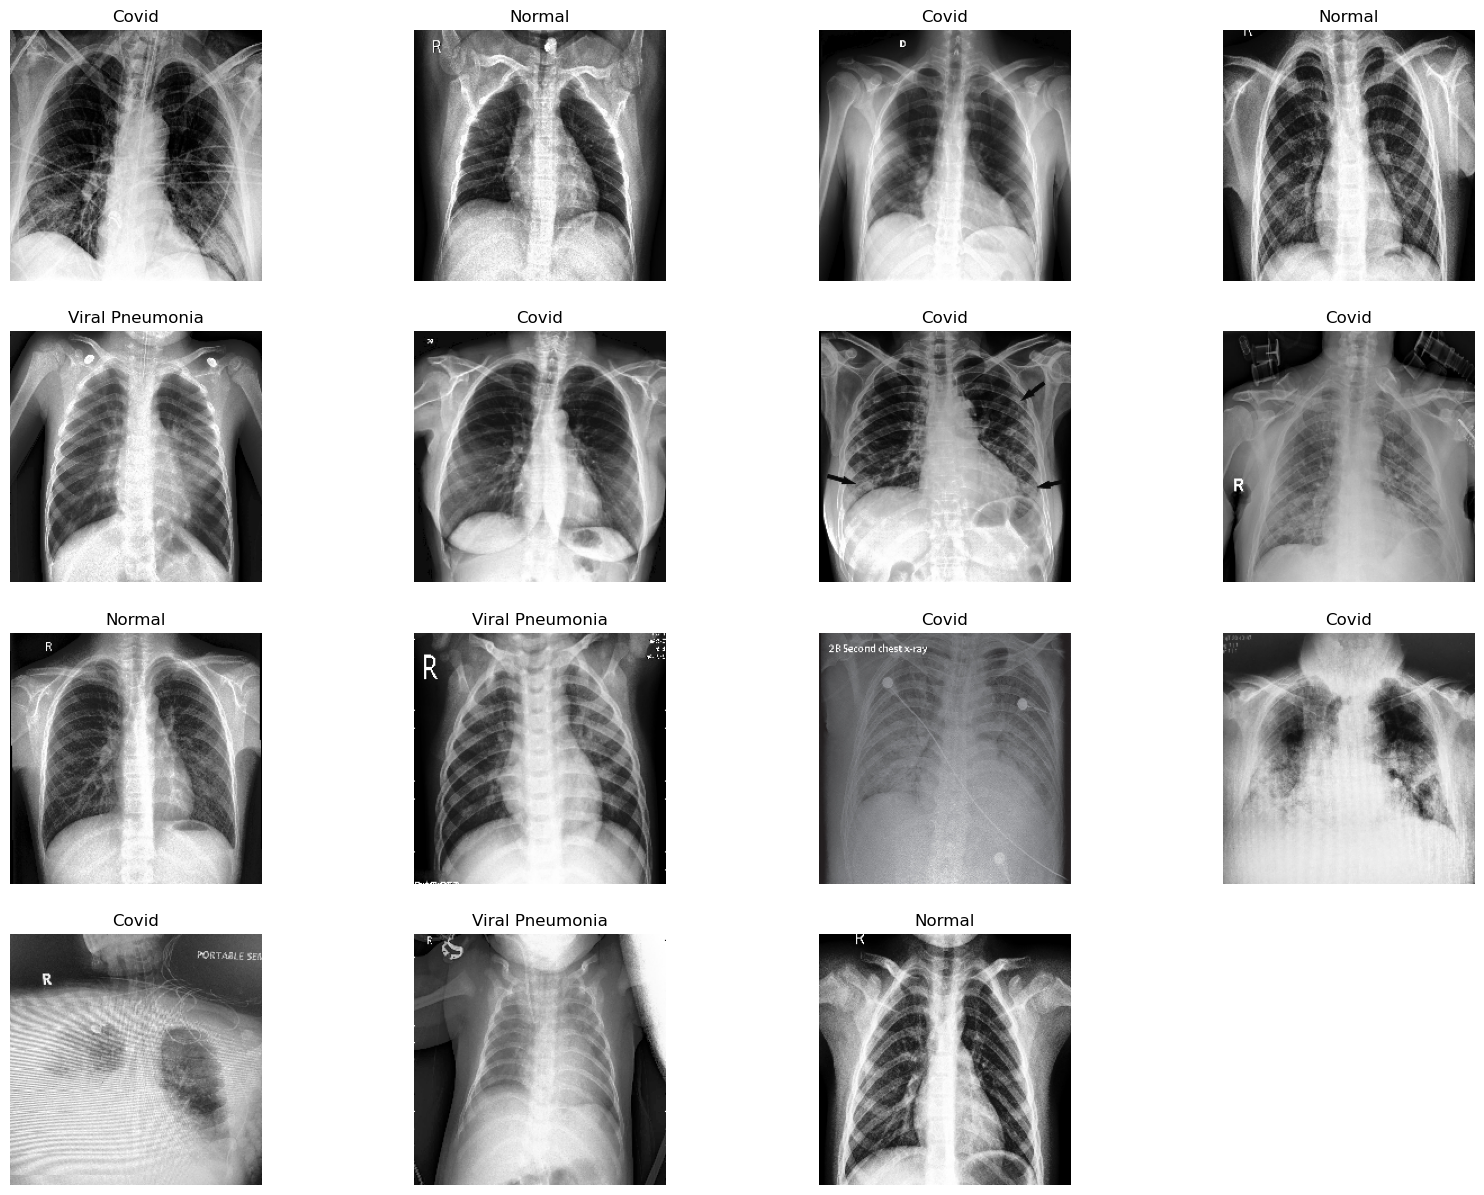

In [3]:
def image_plot(generator,image_numbers):
    img_feature = generator[0][0][:image_numbers]
    img_label = generator[0][1][:image_numbers]

    plt.figure(figsize=(20, 15))
    for i in range(image_numbers):
        ax = plt.subplot(math.ceil(image_numbers/4),4, i + 1)
        plt.imshow(img_feature[i])
        plt.title("Normal" if img_label[i] == 0 else "Viral Pneumonia" if img_label[i] == 1 else "Covid")
        plt.axis("off")

image_plot(train_generator,15)

<h3>VGG16 implementation</h3>

The reason that I added 2 more dense layers is to identify more clearly from the grayscale image.

The dropout layers are regularization for preventing overfitting.

In [4]:
from tensorflow.keras.layers.experimental import preprocessing

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.vgg16.VGG16(
    weights='imagenet', 
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_vgg16 = tf.keras.Sequential()
model_vgg16.add(base_model)
model_vgg16.add(tf.keras.layers.GlobalAveragePooling2D())

model_vgg16.add(tf.keras.layers.Flatten())
model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg16.add(tf.keras.layers.Dropout(0.5))
model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg16.add(tf.keras.layers.Dropout(0.5))

model_vgg16.add(tf.keras.layers.Dense(3, activation='softmax'))

model_vgg16.compile(loss='SparseCategoricalCrossentropy', 
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])
model_vgg16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                        

In [5]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg16_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=5)

callbacks_list = [checkpoint,early]

history = model_vgg16.fit(
        train_generator,
        validation_data = test_generator,
        #steps_per_epoch=10,
        epochs=50, 
        shuffle=False, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/50
4/4 [==============================] - ETA: 0s - loss: 1.1872 - acc: 0.3984
Epoch 1: acc improved from -inf to 0.39841, saving model to model\vgg16_best.h5
4/4 [==============================] - 8s 2s/step - loss: 1.1872 - acc: 0.3984 - val_loss: 1.0290 - val_acc: 0.4848
Epoch 2/50
4/4 [==============================] - ETA: 0s - loss: 1.1394 - acc: 0.3984
Epoch 2: acc did not improve from 0.39841
4/4 [==============================] - 5s 1s/step - loss: 1.1394 - acc: 0.3984 - val_loss: 0.9582 - val_acc: 0.6061
Epoch 3/50
4/4 [==============================] - ETA: 0s - loss: 0.9648 - acc: 0.5578
Epoch 3: acc improved from 0.39841 to 0.55777, saving model to model\vgg16_best.h5
4/4 [==============================] - 5s 1s/step - loss: 0.9648 - acc: 0.5578 - val_loss: 0.8952 - val_acc: 0.6818
Epoch 4/50
4/4 [==============================] - ETA: 0s - loss: 0.9204 - acc: 0.5578
Epoch 4: acc did not improve from 0.55777
4/4 [==============================] - 5s 1s/step - loss:

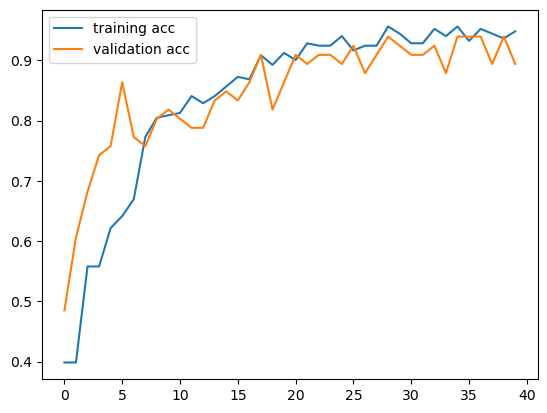

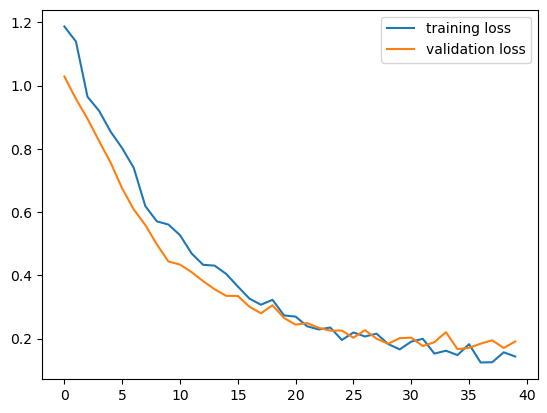

In [6]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.legend();
    plt.figure();

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.legend();

plot_learning_curve(history)

In [7]:
train_result = model_vgg16.evaluate(train_generator)
test_result = model_vgg16.evaluate(test_generator)

no_augmented_df = pd.DataFrame(zip(train_result,test_result),columns=['Train','Val'],index=['Loss','Acc'])
no_augmented_df

2/2 [==============================] - 1s 7ms/step - loss: 0.1664 - acc: 0.9394


,Train,Val
Loss,0.097659,0.166379
Acc,0.968127,0.939394


3/3 [==============================] - 1s 27ms/step
              precision    recall  f1-score   support

         0.0       0.94      0.85      0.89        20
         1.0       0.86      0.95      0.90        20
         2.0       1.00      1.00      1.00        26

    accuracy                           0.94        66
   macro avg       0.94      0.93      0.93        66
weighted avg       0.94      0.94      0.94        66



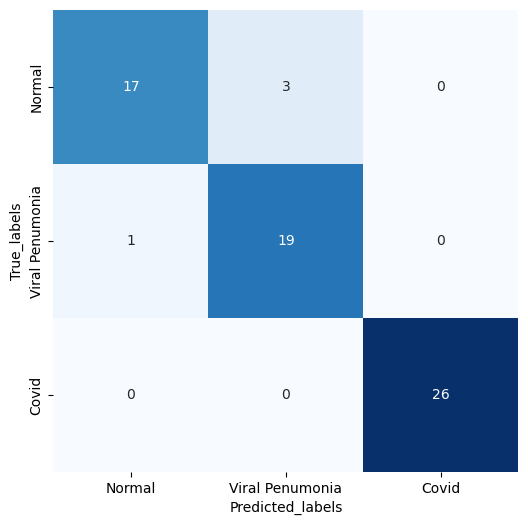

In [8]:
ytest = np.array([])
xtest = []

for i in range(math.ceil(len(test_generator.classes)/batch_size)):
    xtest.append(test_generator[i][0]) 
    ytest= np.concatenate((ytest,test_generator[i][-1])) 
    
xtest = np.concatenate((xtest),axis=0)

ypred_prob =model_vgg16.predict(xtest)
ypred = np.argmax(ypred_prob,axis=1)

plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytest,ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
print(classification_report(ytest,ypred))

<h3>Show the wrong classified image</h3>

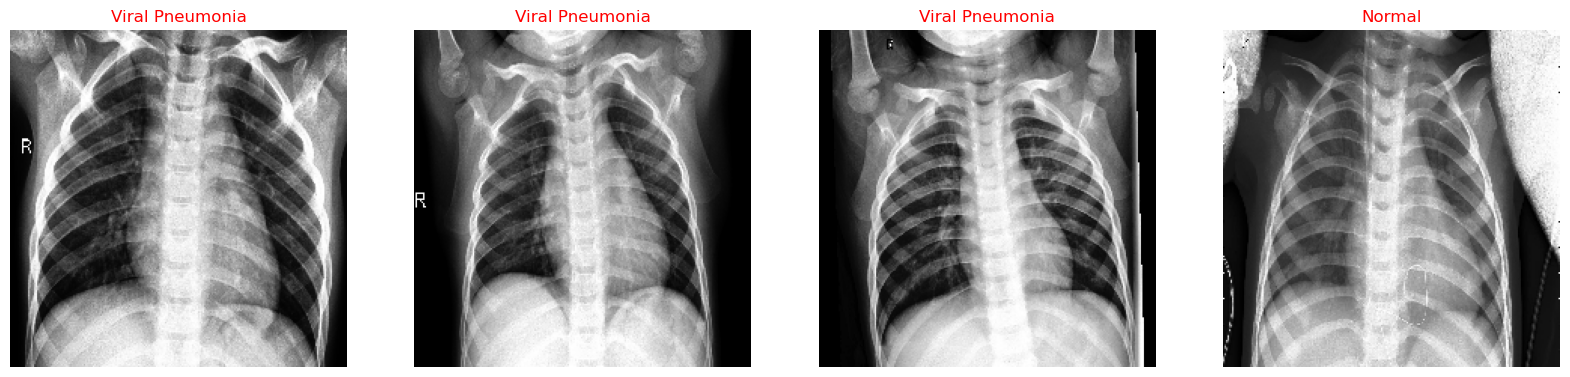

In [9]:
#Extract wrong classification index
wrong_pred = np.where(ypred!=ytest)[0]

plt.figure(figsize=(20, 15))
for i,n in enumerate(wrong_pred):
    ax = plt.subplot(math.ceil(len(wrong_pred)/4),4, i + 1)
    plt.imshow(xtest[n])
    plt.title("Normal" if ypred[n] == 0 else "Viral Pneumonia" if ypred[n] == 1 else "Covid",color='r')
    plt.axis("off")

Well, actually they looks similar 🙃

<h3>Adding image augmentation</h3>

Found 251 images belonging to 3 classes.


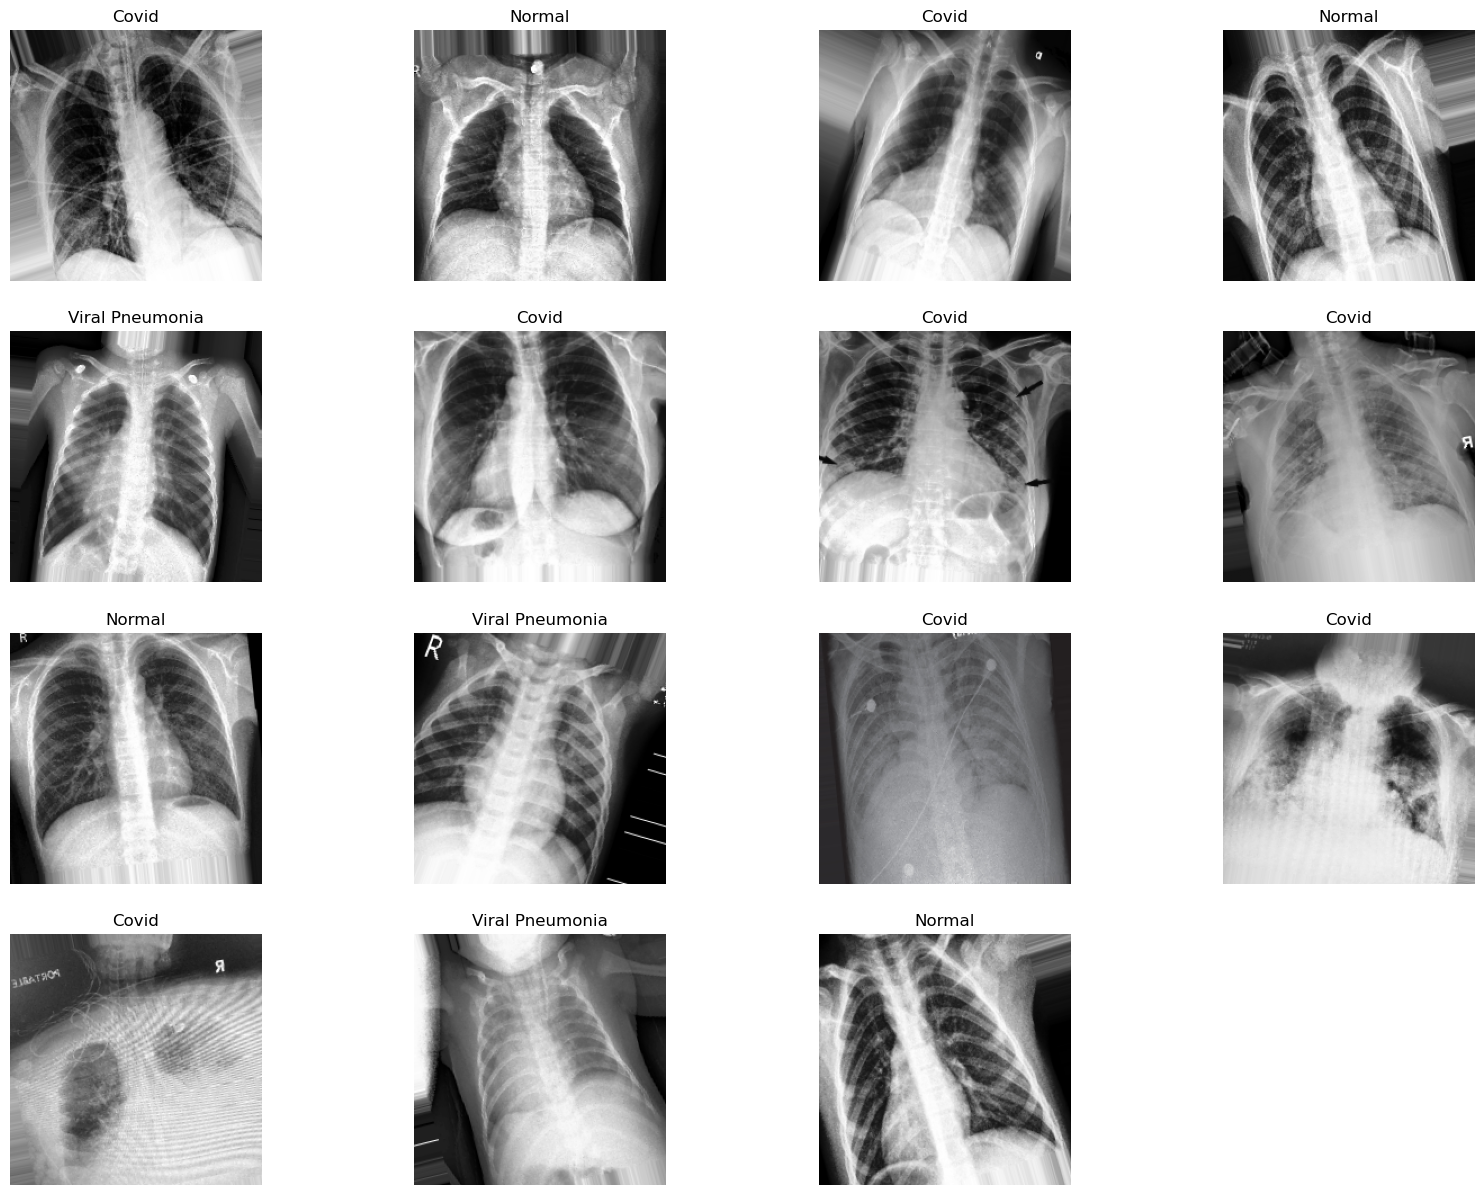

In [10]:
def generate_data_augmented(DIR):
    datagen = ImageDataGenerator(
        rescale=1./255.,
        zoom_range=0.1,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True
    )
    generator = datagen.flow_from_directory(
        TRAINING_DIR,
        batch_size=batch_size,
        seed=42,
        class_mode='binary',
        target_size=(height, width),
        classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2}
    )
    return generator

aug_train_generator = generate_data_augmented(TRAINING_DIR)

image_plot(aug_train_generator,15)

In [11]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg16_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=10)

callbacks_list = [checkpoint,early]

history = model_vgg16.fit(
        aug_train_generator,
        validation_data = test_generator,
        #steps_per_epoch=10,
        epochs=60, 
        shuffle=False, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/60
4/4 [==============================] - ETA: 0s - loss: 0.3360 - acc: 0.8805
Epoch 1: acc improved from -inf to 0.88048, saving model to model\vgg16_best.h5
4/4 [==============================] - 7s 2s/step - loss: 0.3360 - acc: 0.8805 - val_loss: 0.2013 - val_acc: 0.9091
Epoch 2/60
4/4 [==============================] - ETA: 0s - loss: 0.3241 - acc: 0.8845
Epoch 2: acc improved from 0.88048 to 0.88446, saving model to model\vgg16_best.h5
4/4 [==============================] - 6s 2s/step - loss: 0.3241 - acc: 0.8845 - val_loss: 0.2103 - val_acc: 0.8788
Epoch 3/60
4/4 [==============================] - ETA: 0s - loss: 0.2851 - acc: 0.8964
Epoch 3: acc improved from 0.88446 to 0.89641, saving model to model\vgg16_best.h5
4/4 [==============================] - 6s 2s/step - loss: 0.2851 - acc: 0.8964 - val_loss: 0.2012 - val_acc: 0.9091
Epoch 4/60
4/4 [==============================] - ETA: 0s - loss: 0.2912 - acc: 0.8725
Epoch 4: acc did not improve from 0.89641
4/4 [===========

In [12]:
train_result = model_vgg16.evaluate(train_generator)
test_result = model_vgg16.evaluate(test_generator)

augmented_df = pd.DataFrame(zip(train_result,test_result),columns=['Train','Val'],index=['Loss','Acc'])
augmented_df

2/2 [==============================] - 1s 11ms/step - loss: 0.1197 - acc: 0.9848


,Train,Val
Loss,0.082618,0.119651
Acc,0.972112,0.984848


<h3>Final model evaluation</h3>

For training dataset

8/8 [==============================] - 1s 175ms/step
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95        70
         1.0       0.98      0.93      0.96        70
         2.0       1.00      0.99      1.00       111

    accuracy                           0.97       251
   macro avg       0.97      0.97      0.97       251
weighted avg       0.97      0.97      0.97       251



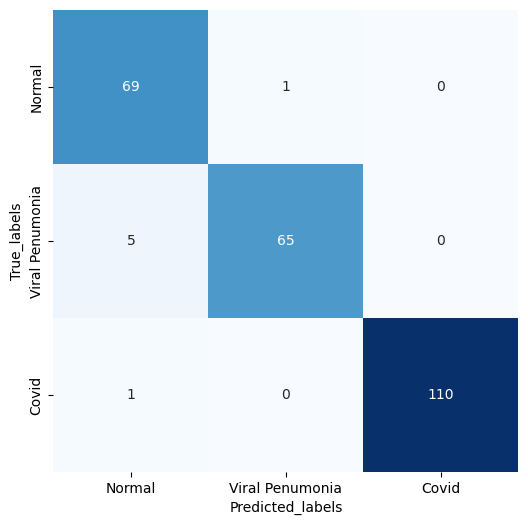

In [13]:
ytrain = np.array([])
xtrain = []

for i in range(math.ceil(len(train_generator.classes)/batch_size)):
    xtrain.append(train_generator[i][0]) 
    ytrain= np.concatenate((ytrain,train_generator[i][-1])) 
    
xtrain = np.concatenate((xtrain),axis=0)

ypred_prob =model_vgg16.predict(xtrain)
ypred = np.argmax(ypred_prob,axis=1)

plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytrain,ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
print(classification_report(ytrain,ypred))

For testing dataset

3/3 [==============================] - 0s 45ms/step
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97        20
         1.0       0.95      1.00      0.98        20
         2.0       1.00      1.00      1.00        26

    accuracy                           0.98        66
   macro avg       0.98      0.98      0.98        66
weighted avg       0.99      0.98      0.98        66



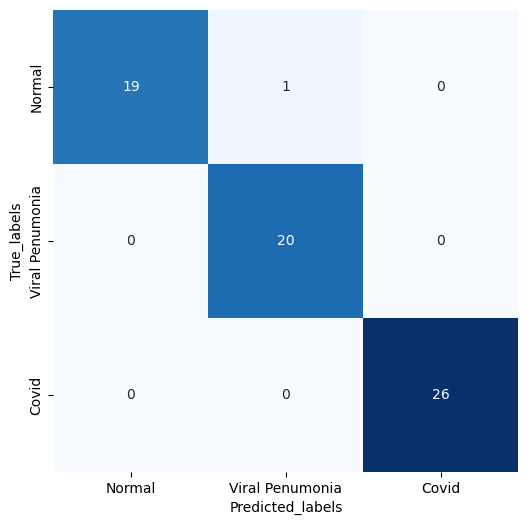

In [14]:
ytest = np.array([])
xtest = []

for i in range(math.ceil(len(test_generator.classes)/batch_size)):
    xtest.append(test_generator[i][0]) 
    ytest= np.concatenate((ytest,test_generator[i][-1])) 
    
xtest = np.concatenate((xtest),axis=0)

ypred_prob =model_vgg16.predict(xtest)
ypred = np.argmax(ypred_prob,axis=1)

plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytest,ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
print(classification_report(ytest,ypred))

<h2>

Great!!

The model can classify all the covid image correctly and overall the accuracy can achieve 98%.

Thanks for viewing my works
    
Your comment matters to me and please feel free to leave it
    
Please upvote if you love it 😀</h2>